# N-Queens

Cost function:


$\begin{equation}
f(x) =  -\sum_i^n \sum_j^n x_{i,j} + \lambda_1(\sum_{i}^n \sum_{j}^n x_{i,j} - N)^2 + \lambda_2\sum_{i_1}^n \sum_{i_2}^n \sum_{i_3}^n \sum_{i_4}^n J_{i_1,i_2,i_3,i_4}x_{i_1,i_2}x_{i_3,i_4}
\end{equation}$

Where $x_{ij}$ = 1 if cell (i,j) contains a queen, 0 otherwise.

The second term, weighted by $\lambda_1$, comes from the constraint that there should be exactly N queens.

The last term, weighted by $\lambda_2$, comes from the constraint that no two queens should attack eachother.
$J_{i_1,i_2,i_3,i_4}$ = 1 if cells $(i_1,i_2)$ y $(i_3, i_4)$ are connected, 0 otherwise.

Expansion of the second term yields linear terms ($x_{ij}$ and $x_{ij}²$) with coefficients $1-2N$, and quadratic terms ($x_{ij}x_{kl}$) with coefficients $2$ (plus a constant term, $N^2$, that can be ommited).

Inclusion of the constraint that there should be exactly N queens (second term) makes much more probable to obtain solutions with exactly N queens, specially for large N. This allows to reduce the number of samples considerably (by orders of magnitude).

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter

import dimod
from dimod import BinaryQuadraticModel

from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler

sampler_simu = SimulatedAnnealingSampler()
sampler_real = EmbeddingComposite(DWaveSampler())
sampler_leap = LeapHybridSampler()

In [150]:
# [s.properties.keys() for s in (sampler_simu, sampler_real, sampler_leap)]

In [151]:
def get_rows(size):
    return range(size)

def get_vars(size):
    rows = get_rows(size)
    return itertools.product(rows, rows)

def get_pairs(size):
    return itertools.combinations(get_vars(size), 2)

In [152]:
def is_valid_solution(solution, size):
    msg = ""
    s = np.array(list(solution.values())).reshape((size,-1))

    if not msg:
        failed_tot_rows = np.sum(s, axis=1) > 1
        if np.count_nonzero(failed_tot_rows):
            msg = f"More than 1 queen per row: {np.nonzero(failed_tot_rows)[0]}."

    if not msg:
        failed_tot_cols = np.sum(s, axis=0) > 1
        if np.count_nonzero(failed_tot_cols):
            msg = f"More than 1 queen per column: {np.nonzero(failed_tot_cols)[0]}."

    if not msg:
        failed_tot_diags = [np.trace(s, k) > 1 for k in range(-size+1, size)]
        if np.count_nonzero(failed_tot_diags):
            msg = f"More than 1 queen per diagonal: {np.nonzero(failed_tot_diags)[0]-size+1}."

    if not msg:
        fs = np.fliplr(s)
        failed_tot_antidiags = [np.trace(fs, k) > 1 for k in range(-size+1, size)]
        if np.count_nonzero(failed_tot_antidiags):
            msg = f"More than 1 queen per anti-diagonal: {-(np.nonzero(failed_tot_antidiags)[0]-size+1)}."

    if not msg:
        tot = np.sum(s)
        if tot != size:
            msg = f"Not exactly {size} queens placed, but {tot}."

    if msg:
        ret = False
    else:
        msg = "Solution is valid."
        ret = True
    return (ret, msg)

In [153]:
def show_solutions(solutions, size):
    n = len(solutions)
    fig, ax = plt.subplots(1, n, figsize=(5*n, 3))
    if n ==1:
        ax = (ax,)
    for solution, iax in zip(solutions, ax):
        valid, msg = is_valid_solution(solution, size)
        s = np.array(list(solution.values())).reshape((size,-1))
        iax.imshow(s)
        iax.set_xticks(np.arange(-.5, size, 1))
        iax.set_yticks(np.arange(-.5, size, 1))
        iax.set_xticklabels(np.arange(0, size+1, 1))
        iax.set_yticklabels(np.arange(0, size+1, 1))
        iax.grid()
        iax.set_title(f"Num. Queens: {np.sum(s)} / {size}.\nValid: {valid}\n{msg}")

In [154]:
def get_qm(size, lin_term, lagrange_attack, lagrange_exact_n):
    qm = dimod.BinaryQuadraticModel("BINARY")

    if lin_term:
        # Enumerate all states and assign linear coefficient. The more negative, the less energy and the more favoured. 
        qubo_dict_linears = {c:lin_term for c in get_vars(size)}
        qm.add_linear_from(qubo_dict_linears)

    if lagrange_attack:
        # Enumerate pairs along same row, column or (anti)diagonal, and assign the quadratic coefficient.
        qubo_dict_quadratic_attack = {c: lagrange_attack for c in get_pairs(size) if (
                c[0][0] == c[1][0] or
                c[0][1] == c[1][1] or
                c[0][0] - c[1][0] == c[0][1] - c[1][1] or
                c[0][0] - c[1][0] == c[1][1] - c[0][1]
            )
        }
        qm.add_quadratic_from(qubo_dict_quadratic_attack)

    # QUBO model that represents the constraint: exactly N queens. Applying penalty factor.
    if lagrange_exact_n:
        # One single condition: Exactly N queens in total.
        # q = dimod.generators.combinations(list(get_vars(size)), size, strength=lagrange_exact_n)
        # qm.update(q)
        for j in range(size):
            # Several constraints: exactly 1 queen per row, per column. (TODO: for (anti)diagonals, 0 or 1 queens)
            q = dimod.generators.combinations(list(filter(lambda x: x[0]==j, get_vars(size))), 1, strength=lagrange_exact_n)
            qm.update(q)
            q = dimod.generators.combinations(list(filter(lambda x: x[1]==j, get_vars(size))), 1, strength=lagrange_exact_n)
            qm.update(q)
    return qm

In [155]:
def show_problem(qm):
    q = qm.copy()
    q.relabel_variables_as_integers(inplace=True)
    m = q.to_numpy_matrix()
    plt.imshow(m, cmap="RdBu")
    plt.colorbar()
    return m

In [156]:
N = 8 # NxN board, up to N queens.

# Samples and problem label.
num_reads_simu = 10
num_reads_real = 4_000
num_reads_leap = None
problem_label_simu = f"N-queens size {N} (simu), {num_reads_simu} num_reads"
problem_label_real = f"N-queens size {N} (real), {num_reads_real} num_reads"
problem_label_leap = f"N-queens size {N} (leap), {num_reads_real} num_reads"

/home/casa/anaconda3/envs/dwave_ocean_extra/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0
  after removing the cwd from sys.path.


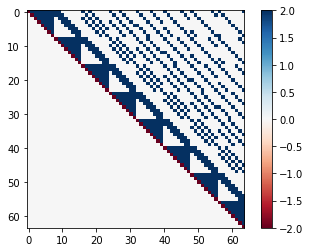

In [157]:
# Base cost function - Add as many queens as possible: lin_term = -1.
lin_term = -1 * 2

# Constraint: Penalize not placing exactly n queens / 1 queen per row and column.
lagrange_exact_n = 1 * 0

# Constraint: Penalize any two queens attacking eachother.
lagrange_attack = 1 * 2

# Best results
# - for the real sampler: lin_term=2, lagrange_exact_n=0, lagrange_attack=2 with >4000 reads. Find 1 or 2 valid solutions at most.
# - for the hybrid sampler: almost always finds a valid solution


# Build the Binary Quadratic Model.
qm = get_qm(N, lin_term, lagrange_attack, lagrange_exact_n)
m = show_problem(qm)

2.0


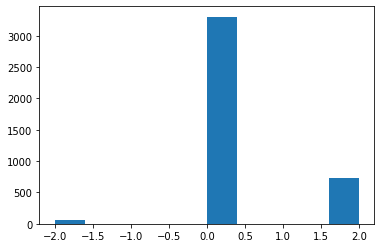

In [158]:
print(np.max(m))
plt.hist(m.reshape((-1,1)))
plt.show()

CPU times: user 298 ms, sys: 3.8 ms, total: 302 ms
Wall time: 298 ms


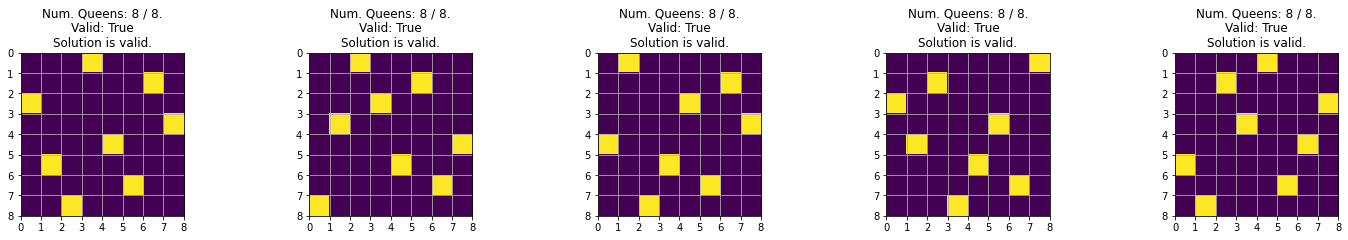

In [160]:
%%time
# Run on Simulator.
sampleset_simu = sampler_simu.sample(qm, label=problem_label_simu, num_reads=num_reads_simu)
# solution_simu = sampleset_simu.first.sample
show_solutions(sampleset_simu.samples(5), N)

CPU times: user 21.6 s, sys: 149 ms, total: 21.8 s
Wall time: 26.6 s


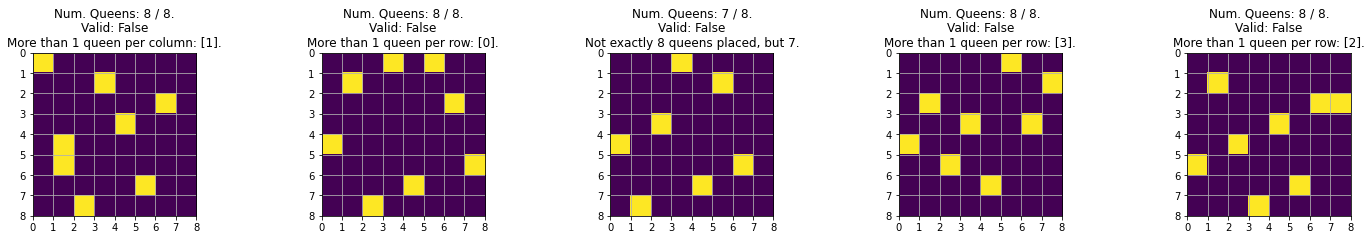

In [161]:
%%time
# Run on Real Annealer.
sampleset_real = sampler_real.sample(qm, label=problem_label_real, num_reads=num_reads_real)
# solution_real = sampleset_real.first.sample
show_solutions(sampleset_real.samples(5), N)

Minimum time limit required: 3.0
CPU times: user 266 ms, sys: 25 ms, total: 291 ms
Wall time: 17.1 s


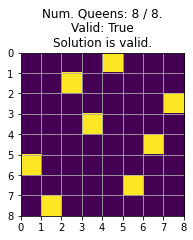

In [163]:
%%time
# Run on Leap Hybrid solver.
time_limit = sampler_leap.min_time_limit(qm)
print(f"Minimum time limit required: {time_limit}")
sampleset_leap = sampler_leap.sample(qm, label=problem_label_leap)
# solution_leap = sampleset_leap.first.sample
show_solutions(sampleset_leap.samples(5), N)